<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

<html><font size=4><B>1. Κατασκευή γράφου και υπολογισμός μετρικών</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/maayan-pdzbase/"> KONECT (PDZBase) </a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$. Οι κόμβοι του γράφου αναπαριστούν πρωτεΐνες και οι ακμές την αλληλεπίδραση αυτών. Στην σελίδα <a href="http://konect.cc/networks/maayan-pdzbase/"> KONECT (PDZBase)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί.<BR></html>

Number of duplicates: 0


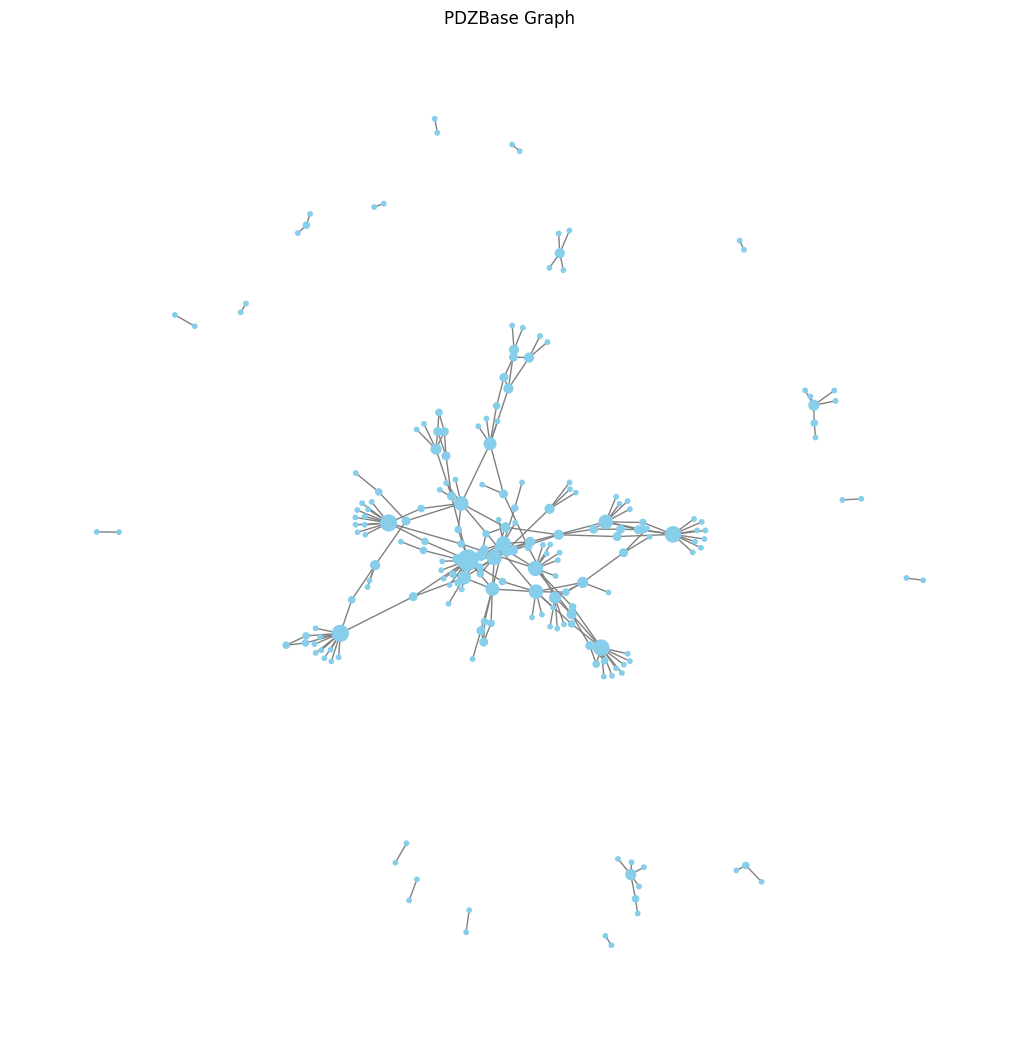

In [2]:
edges = []
duplicates = 0
with open("out.maayan-pdzbase", 'r') as file:
    for line in file:
        if not line.startswith('%'):  # Αγνοούμε γραμμές σχολίων
            node1, node2 = map(int, line.strip().split())
            if (node1, node2) not in edges and (node2, node1) not in edges and node1 != node2:
              edges.append((node1, node2))
            elif node1 != node2:
              duplicates += 1

print(f"Number of duplicates: {duplicates}")

# Δημιουργία γράφου
G = nx.Graph()
G.add_edges_from(edges)

# Σχεδίαση του γράφου
node_sizes = [G.degree(node) * 10 for node in G.nodes()]
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    font_size=8
)
plt.title("PDZBase Graph", fontsize=12)
plt.show()

 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [3]:
initial_node_count=len(G.nodes)
initial_edge_count=len(G.edges)
initial_mean_degree=np.mean([G.degree(node) for node in G.nodes])
initial_connected_components=nx.number_connected_components(G)

print(f"Number of nodes: {initial_node_count}")
print(f"Number of edges: {initial_edge_count}")
print(f"Mean degree: {initial_mean_degree:.4f}")
print(f"Number of connected components: {initial_connected_components}")

Number of nodes: 212
Number of edges: 242
Mean degree: 2.2830
Number of connected components: 19


<li><B>2 Προεργασία για την πρόβλεψη συνδέσμων. 2(i). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [4]:
adj_matrix = nx.to_numpy_array(G)
n = len(adj_matrix)
unconnected_pairs = []

for i in range(n):
    for j in range(i + 1, n):
        if adj_matrix[i, j] == 0:
            unconnected_pairs.append((i+1, j+1))

print("Number of unconnected pairs:", len(unconnected_pairs))

Number of unconnected pairs: 22124


<li><B>2(ii).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [5]:
# removable edges: check splitting and number of nodes
removable_edges = []
G_copy = G.copy()
for edge in G.edges:
    G_copy.remove_edge(*edge)

    if (nx.number_connected_components(G_copy) == initial_connected_components
        and len(G_copy.nodes) == initial_node_count):
        removable_edges.append(edge)
    else:
        G_copy.add_edge(*edge)

print("Number of removable edges:", len(removable_edges))

Number of removable edges: 49


<li><B>2(iii).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 2(i) και 2(ii) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>2(iv).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 2(ii). <BR>
    <li><B>2(v).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [6]:
#dataframe of removable edges (they will function as positive samples)
df_removable = pd.DataFrame(removable_edges, columns=["node1", "node2"])
df_removable["link"] = 1

#dataframe of unconnected node pairs (they will function as negative samples)
df_unconnected = pd.DataFrame(unconnected_pairs, columns=["node1", "node2"])
df_unconnected["link"] = 0

#merge in one dataframe
df_combined = pd.concat([df_removable, df_unconnected], ignore_index=True)

#build graph G'=G_reduced
G_reduced = G.copy()
G_reduced.remove_edges_from(removable_edges)

print(f"Number of nodes: {len(G_reduced.nodes)}")
print(f"Number of edges: {len(G_reduced.edges)}")
print(f"Mean degree: {np.mean([G_reduced.degree(node) for node in G_reduced.nodes]):.4f}")
print(f"Number of connected components: {nx.number_connected_components(G_reduced)}")

Number of nodes: 212
Number of edges: 193
Mean degree: 1.8208
Number of connected components: 19


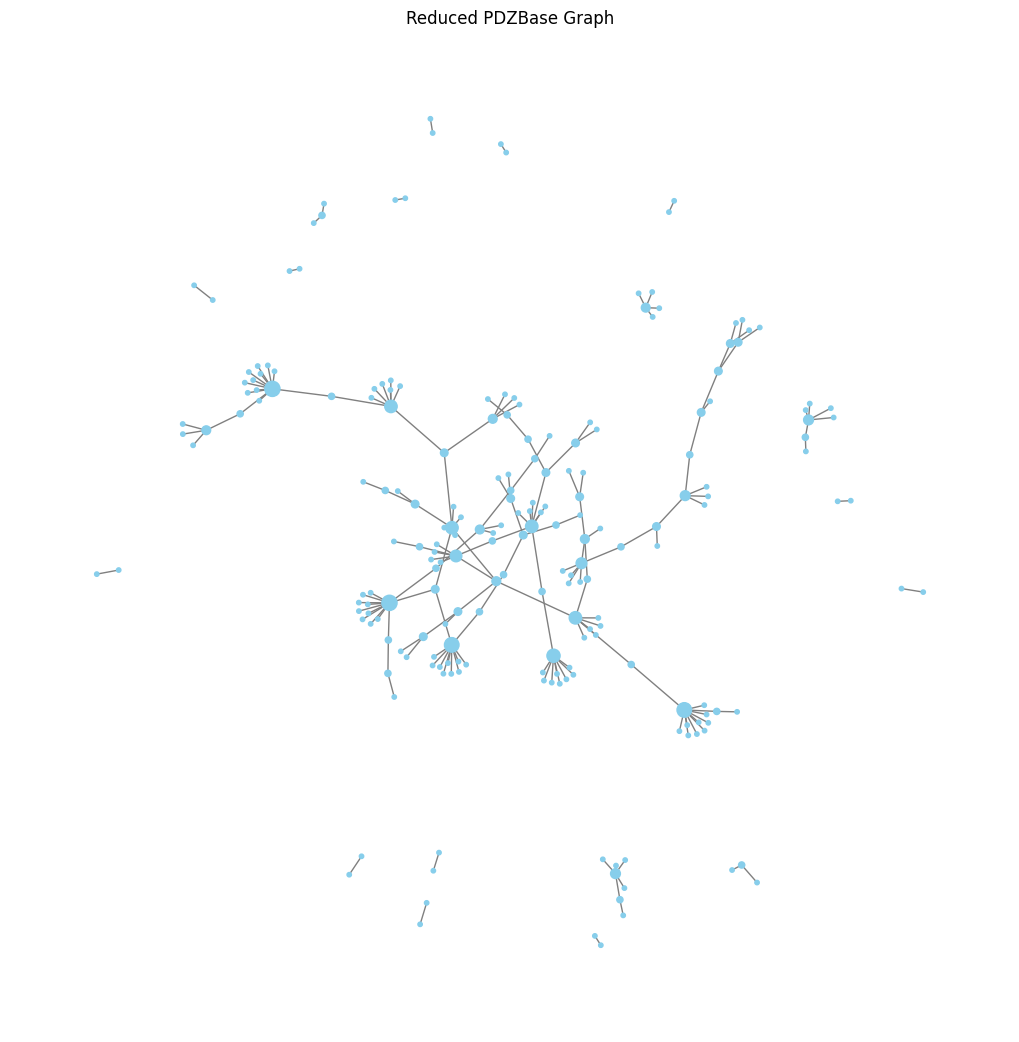

In [7]:
# Σχεδίαση του γράφου
node_sizes = [G_reduced.degree(node) * 10 for node in G_reduced.nodes()]
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_reduced, seed=42)
nx.draw(
    G_reduced, pos,
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    font_size=8
)
plt.title("Reduced PDZBase Graph", fontsize=12)
plt.show()

<html><font size=4><B>3. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>3(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων:
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [8]:
!pip install node2vec

In [9]:
from node2vec import Node2Vec
import multiprocessing

#generate walks
node2vec_walker = Node2Vec(G_reduced, p=1.0, q=1.0, dimensions=128,
                           num_walks=10, walk_length=80,
                           workers=multiprocessing.cpu_count())

#train node2vec model
n2v_model = node2vec_walker.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/212 [00:00<?, ?it/s]

<html><font>
    <li><B>3(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>3(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [10]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df_combined['node1'], df_combined['node2'])]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, df_combined['link'], random_state = 0)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [13]:
# Πρόβλεψη στο σύνολο δοκιμής
y_pred = classifier.predict(X_test)

In [14]:
# Υπολογισμός ακρίβειας
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest Classifier: {accuracy:.2f}")

Accuracy of the Random Forest Classifier: 1.00
